In [ ]:
# # prompt: get the drive connected to the notebook

# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!python --version

Python 3.11.11


In [2]:
# pip uninstall torch torchvision torchaudio torch-cluster torch-geometric -y

In [3]:
import subprocess
import sys

def run_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()
    return output.decode(), error.decode()

# Install PyTorch with CUDA support
cmd = f"{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121"
output, error = run_command(cmd)
print("Output:", output)
print("Error:", error if error else "No errors")

Output: Looking in indexes: https://download.pytorch.org/whl/cu121

Error: No errors


In [4]:
import subprocess
import sys

def run_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()
    return output.decode(), error.decode()

# Install torch-cluster for PyTorch 2.5.1+cu121
cmd = f"{sys.executable} -m pip install torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu121.html"
output, error = run_command(cmd)
print("Output:", output)
print("Error:", error if error else "No errors")

Output: Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html

Error: No errors


In [5]:
try:
    from torch_cluster import knn  # Test import
    print("torch-cluster installed successfully!")
except ImportError as e:
    print(f"Failed to import torch-cluster: {e}")

torch-cluster installed successfully!


In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
!pip install torch_geometric

In [8]:
import torch
print(torch.__version__)
print(torch.version.cuda)  # Should return the CUDA version if available
print(torch.backends.cudnn.enabled)  # Should be True if CUDA is properly configured


2.5.1+cu121
12.1
True


if cuda version none - install pytorch with cuda

# Installing and laoding cuda and othe packages

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


GPU is available. Using: NVIDIA GeForce RTX 3090


In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [12]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


e:\Danilka\AutoMesh\AutoMesh-GGT-VQ\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading dataset 

In [13]:
import os
import json
import torch
from torch_geometric.data import Data

def preprocess_object(obj, caption_text, tokenizer, device):
    vertices = torch.tensor(obj['v'], dtype=torch.float, device=device)
    edges = torch.tensor(obj['e'], dtype=torch.long, device=device).t()

    # Tokenize the caption text.
    inputs = tokenizer(caption_text, return_tensors="pt", padding=True, truncation=True, max_length=32)
    # Move tokenized inputs to device.
    input_ids = inputs["input_ids"].to(device=device, dtype=torch.long)
    attention_mask = inputs.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device=device, dtype=torch.long)

    # Instead of computing embeddings with torch.no_grad(), we store the tokenized text.
    text_label = {"input_ids": input_ids, "attention_mask": attention_mask}
    
    return Data(x=vertices, edge_index=edges, text_label=text_label)

def load_json_and_caption(json_file_path, tokenizer, device):
    """
    Loads the JSON data from json_file_path and locates the corresponding caption file.
    Returns a graph Data object.
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        obj = json.load(f)

    # Derive the base name from the JSON filename (e.g., 'model_id' from 'model_id.json')
    base_name = os.path.splitext(os.path.basename(json_file_path))[0]
    folder_path = os.path.dirname(json_file_path)

    # Attempt to find a caption file in the same folder (e.g., 'model_id_45_caption.txt')
    caption_text = ""
    for file_name in os.listdir(folder_path):
        if file_name.startswith(base_name) and file_name.endswith("_caption.txt"):
            caption_file_path = os.path.join(folder_path, file_name)
            with open(caption_file_path, 'r', encoding='utf-8') as cf:
                caption_text = cf.read().strip()
            break
            
    # Fallback: if no caption file is found, use obj['n'] if available
    if not caption_text:
        print(f"No matching caption file found for {base_name}, using obj['n'] if available.")
        caption_text = obj.get('n', '')

    return preprocess_object(obj, caption_text, tokenizer, device)

def create_dataset(root_folder, tokenizer, device, max_nodes=2500):
    """
    Iterates through subfolders in the root folder, loads JSON mesh data and caption files,
    and filters out any data points with more than max_nodes nodes.
    
    The folder structure is assumed to be:
      root_folder/
          model_id/
              model_id.json
              model_id_45_caption.txt
    """
    dataset = []

    # List all items in the root folder
    for model_id in os.listdir(root_folder):
        model_folder = os.path.join(root_folder, model_id)
        if os.path.isdir(model_folder):
            json_filename = f"{model_id}.json"
            json_path = os.path.join(model_folder, json_filename)
            
            if os.path.exists(json_path):
                data = load_json_and_caption(json_path, tokenizer, device)
                
                # Filter out data with more than max_nodes nodes
                num_nodes = data.x.size(0)
                print()
                if num_nodes > max_nodes:
                    print(f"Skipping {json_path} due to excessive nodes: {num_nodes} (max allowed {max_nodes}).")
                else:
                    dataset.append(data)
                    print(f"Loaded data from {json_path} with {num_nodes} nodes.")
            else:
                print(f"No JSON file found for {model_id} in {model_folder}. Skipping.")
        else:
            print(f"{model_id} is not a directory. Skipping.")

    return dataset

# Example usage:
# Make sure to initialize your tokenizer and BERT model appropriately:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# root_folder = "path/to/processed_models"
# dataset = create_dataset(root_folder, tokenizer, device, max_nodes=5000)


In [14]:
def filter_dataset_by_node_count(dataset, max_nodes=2500):
    """
    Filters the dataset to remove data points with more than max_nodes and returns the
    filtered dataset along with the minimum and maximum node counts.

    Args:
        dataset (list): List of PyG Data objects.
        max_nodes (int): Maximum allowed number of nodes.

    Returns:
        tuple: A tuple containing:
            - filtered_dataset (list): Data points with at most max_nodes nodes.
            - min_node_count (int or None): Minimum node count among filtered data, or None if empty.
            - max_node_count (int or None): Maximum node count among filtered data, or None if empty.
    """
    filtered_dataset = [data for data in dataset if data.x.size(0) <= max_nodes and data.x.size(0) > 700]
    
    if filtered_dataset:
        node_counts = [data.x.size(0) for data in filtered_dataset]
        min_node_count = min(node_counts)
        max_node_count = max(node_counts)
    else:
        min_node_count, max_node_count = None, None

    return filtered_dataset, min_node_count, max_node_count


In [15]:


def load_data_and_split(folder_path,tokenizer,device ):
    dataset = create_dataset(folder_path,tokenizer,device)
    filtered_dataset, min, max = filter_dataset_by_node_count(dataset)
    min_node_count = min
    max_node_count = max
    train_size = int(0.8 * len(filtered_dataset))
    val_size = int(0.1 * len(filtered_dataset))
    test_size = len(filtered_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        filtered_dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset, min_node_count, max_node_count

# dataset

In [16]:
train_dataset, val_dataset, test_dataset, min_node_count, max_node_count = load_data_and_split('E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models',tokenizer,device)


Skipping E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\10155655850468db78d106ce0a280f87\10155655850468db78d106ce0a280f87.json due to excessive nodes: 2645 (max allowed 2500).

Loaded data from E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\1021a0914a7207aff927ed529ad90a11\1021a0914a7207aff927ed529ad90a11.json with 1333 nodes.

Loaded data from E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\1026dd1b26120799107f68a9cb8e3c\1026dd1b26120799107f68a9cb8e3c.json with 1608 nodes.

Skipping E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\103c9e43cdf6501c62b600da24e0965\103c9e43cdf6501c62b600da24e0965.json due to excessive nodes: 3422 (max allowed 2500).

Skipping E:\Danilka\AutoMesh\preprocessed-airplane-captions-sample\captioned_models\105f7f51e4140ee4b6b87e72ead132ed\105f7f51e4140ee4b6b87e72ead132ed.json due to excessive nodes: 2936 (max allowed 2500).

Loaded data from E:\Danilka\

In [17]:
print(min_node_count , "minimum")
print(max_node_count , "maximum")
# Example usage:
print(f"Original dataset size: {len(train_dataset)}")

702 minimum
2500 maximum
Original dataset size: 644


# Visualization

Vertices: 6747
Edges: 8582
Text: {'input_ids': tensor([[  101,  1996,  7605,  2944,  2838,  1037, 29445, 13478,  2007,  1037,
          3940,  1997, 17876,  1010,  7260,  1011,  2067,  4777,  1998,  1037,
          5664,  5725,  2930,  1012,  2049,  3252,  2950,  2176,  7471, 27790,
          2869,   102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


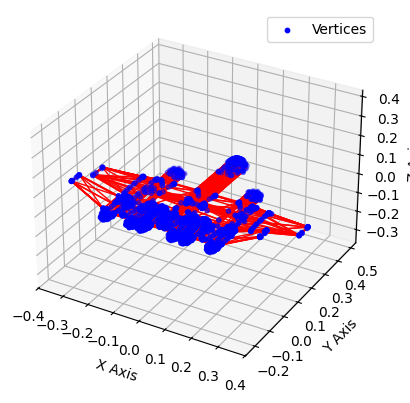

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize the 3D graph
def visualize_3d(vertices, edges):
    """
    Visualize a 3D graph given vertices and edges.

    :param vertices: numpy array of shape (n, 3) representing the 3D coordinates of the vertices.
    :param edges: numpy array of shape (2, m) where each column represents an edge (start_index, end_index).
    """
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure vertices are a numpy array
    vertices = np.array(vertices)

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='o', s=10, label="Vertices")

    # Plot edges
    for i in range(edges.shape[1]):
        v1, v2 = edges[:, i]  # Each column represents an edge (start_index, end_index)
        ax.plot([vertices[v1, 0], vertices[v2, 0]],
                [vertices[v1, 1], vertices[v2, 1]],
                [vertices[v1, 2], vertices[v2, 2]], c='r', linewidth=1)

    # Set plot labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    # Set equal scaling for all axes
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0

    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Display the plot
    plt.show()

# Extract vertices and edges from the dataset
vertices_np, edges_np, text_label = train_dataset[1].x.cpu().numpy(), train_dataset[1].edge_index.cpu().numpy(),train_dataset[1].text_label

# Print the first graph's data for verification
print("Vertices:", vertices_np.size)
print("Edges:", edges_np.size)
print("Text:", text_label)

# Visualize the first graph
visualize_3d(vertices_np, edges_np)


In [19]:
import torch.nn as nn

class NodeCountPredictor(nn.Module):
    def __init__(self, latent_dim):
        super(NodeCountPredictor, self).__init__()
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Predict a single scalar
        )

    def forward(self, z):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            predicted_node_count: Scalar prediction for the number of nodes
        """
        return self.node_count_predictor(z).squeeze(-1)

def pretrain_node_count_predictor(predictor, data_loader, optimizer, device, num_epochs=10):
    predictor.train()
    loss_fn = nn.MSELoss()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in data_loader:
            data = data.to(device)
            z = data.latent_vector  # Use precomputed latent vector
            true_num_nodes = data.num_nodes  # Ground truth node count
            
            # Forward pass
            predicted_num_nodes = predictor(z)
            
            # Compute loss
            loss = loss_fn(predicted_num_nodes, true_num_nodes.float())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(data_loader):.4f}")


# NodeCountPredictor()
# pretrain_node_count_predictor()

# Encoders

In [20]:
# class BertTextEncoder(nn.Module):
#     def __init__(self, bert_model_name="bert-base-uncased", force_bert=False, freeze_layers=8):
#         super(BertTextEncoder, self).__init__()
#         self.bert = BertModel.from_pretrained(bert_model_name)
#         self.hidden_dim = self.bert.config.hidden_size
#         self.force_bert = force_bert

#         # Freeze embeddings and lower layers
#         for param in self.bert.embeddings.parameters():
#             param.requires_grad = False
#         # Freeze the first freeze_layers encoder layers
#         for layer in self.bert.encoder.layer[:freeze_layers]:
#             for param in layer.parameters():
#                 param.requires_grad = False

#     def forward(self, text_input):
#         if isinstance(text_input, dict):
#             input_ids = text_input["input_ids"]
#             attention_mask = text_input.get("attention_mask", None)
#             print("attension")
#         else:
#             input_ids = text_input
#             attention_mask = None

#         if input_ids.dim() == 3 and input_ids.size(-1) == self.hidden_dim and not self.force_bert:
#             return input_ids

#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         embeddings = outputs.last_hidden_state
#         return embeddings


In [21]:
from transformers import DistilBertModel

class BertTextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", force_bert=False):
        super(BertTextEncoder, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.hidden_dim = self.bert.config.dim  # DistilBERT uses 'dim' instead of 'hidden_size'
        self.force_bert = force_bert

    def forward(self, text_input):
        if isinstance(text_input, dict):
            input_ids = text_input["input_ids"]
            attention_mask = text_input.get("attention_mask", None)
        else:
            input_ids = text_input
            attention_mask = None

        if input_ids.dim() == 3 and input_ids.size(-1) == self.hidden_dim and not self.force_bert:
            return input_ids

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        return embeddings


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# "text_encoder": TransformerTextEncoder(embed_dim=768, num_heads=4, num_layers=2).to(device),
    # "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64, num_layers=3).to(device),
    # "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),

# Transformer Encoder
class TransformerTextEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerTextEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )

    def forward(self, text_input):
        """
        Args:
            text_input: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            encoded_text: Tensor of shape [batch_size, seq_len, embed_dim]
        """
        # Transpose to match Transformer input format: [seq_len, batch_size, embed_dim]
        text_input = text_input.permute(1, 0, 2)

        # Encode text
        encoded_text = self.transformer(text_input)  # Shape: [seq_len, batch_size, embed_dim]

        # Transpose back to [batch_size, seq_len, embed_dim]
        return encoded_text.permute(1, 0, 2)

class GraphEncoder(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32, out_channels=64):
        super(GraphEncoder, self).__init__()
        self.layer1 = GCNConv(in_channels, hidden_channels)  # 3 -> 32
        self.layer2 = GCNConv(hidden_channels, hidden_channels)  # 32 -> 32
        self.layer3 = GCNConv(hidden_channels, out_channels)  # 32 -> 64

    def forward(self, x, edge_index):
        x = F.relu(self.layer1(x, edge_index))
        x = F.relu(self.layer2(x, edge_index))
        x = self.layer3(x, edge_index)  # No ReLU on final layer
        return x.mean(dim=0)  # Pooling to get latent feature z_G

# Feature Fusion
import torch
import torch.nn as nn

class FeatureFusion(nn.Module):
    def __init__(self, text_dim, graph_dim, fused_dim):
     
        super(FeatureFusion, self).__init__()
        self.fc1 = nn.Linear(text_dim + graph_dim, 512)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(512, fused_dim)

    def forward(self, c_text, z_G):
      
        c_text_pooled = c_text.mean(dim=1)  # Shape: [batch_size, text_dim]

        # Ensure z_G is at least 2D (batch_size, graph_dim)
        if z_G.ndim == 1:
            z_G = z_G.unsqueeze(0).expand(c_text_pooled.size(0), -1)

        # Concatenate features from text and graph
        combined_features = torch.cat([c_text_pooled, z_G], dim=-1)  # Shape: [batch_size, text_dim + graph_dim]

        # Pass through the first fully connected layer and activation (bottleneck)
        hidden_features = self.activation(self.fc1(combined_features))  # Shape: [batch_size, hidden_dim]

        # Pass through the final fully connected layer to produce fused features
        fused_features = self.fc2(hidden_features)  # Shape: [batch_size, fused_dim]
        return fused_features



class VectorQuantization(nn.Module):
    def __init__(self, codebook_size, embedding_dim, beta=1):
        super().__init__()
        self.codebook_size = codebook_size
        self.embedding_dim = embedding_dim
        self.beta = beta
        self.codebook = nn.Embedding(codebook_size, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

    def forward(self, z):
        z_flattened = z.view(-1, z.size(-1))
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     - 2 * torch.matmul(z_flattened, self.codebook.weight.T)
                     + torch.sum(self.codebook.weight**2, dim=1))
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.codebook(encoding_indices).view(z.shape)
        # Commitment loss
        commit_loss = F.mse_loss(z, z_q.detach())
        # Codebook loss
        codebook_loss = F.mse_loss(z_q, z.detach())
        loss = commit_loss + self.beta * codebook_loss
        z_q = z + (z_q - z).detach()  # Straight-through estimator
        return z_q, encoding_indices, loss

# Graph Decoder 
-> taking VQ and making node features and adjacent matrix

In [ ]:
from torch_geometric.nn import knn_graph

class EdgeDecoder(nn.Module):
    def __init__(self, node_dim, hidden_dim=64, k=4):
        super().__init__()
        self.k = k  
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_dim, hidden_dim),
            nn.Dropout(0.5),  
            nn.Softmax(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, node_embeddings):
        num_nodes = node_embeddings.size(0)
        # Use k-NN to get candidate edges
        edge_index = knn_graph(node_embeddings, k=self.k, loop=False)
        node_i = node_embeddings[edge_index[0]]
        node_j = node_embeddings[edge_index[1]]
        pairwise_input = torch.cat([node_i, node_j], dim=-1)
        edge_logits = self.mlp(pairwise_input)
        adj = torch.zeros(num_nodes, num_nodes, device=node_embeddings.device)
        adj[edge_index[0], edge_index[1]] = torch.sigmoid(edge_logits).squeeze()
        adj = adj + adj.T  # Ensure symmetry
        return adj

In [ ]:
        # self.min_node_count = min_node_count
        # self.max_node_count = max_node_count
class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, node_dim, edge_hidden_dim=64, min_node_count=50, max_node_count=10000):
        super().__init__()

        self.node_decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.Softmax(),
            nn.Dropout(0.5),  # Added dropout to prevent collapse
            nn.Linear(64, node_dim)
        )
        # self.node_count_predictor = nn.Sequential(
        #     nn.Linear(latent_dim, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 1),
        #     nn.ReLU()
        # )
        # mid_point = min_node_count + (max_node_count - min_node_count) / 2
        # self.node_count_predictor[2].bias.data.fill_(mid_point)
        self.edge_decoder = EdgeDecoder(node_dim, hidden_dim=edge_hidden_dim)
        self.noise_factor = 0.5 # Noise factor for node decoding
    def forward(self, z, true_num_nodes=None):
        batch_size = z.size(0)
        assert batch_size == 1, "Currently, this decoder supports only batch_size=1."
        # raw_node_counts = self.node_count_predictor(z).squeeze(-1)  # [batch_size]
        # predicted_num_nodes = torch.clamp(raw_node_counts.round(), min=self.min_node_count, max=self.max_node_count).long()  # Keep as tensor
        # num_nodes = true_num_nodes if true_num_nodes is not None else predicted_num_nodes.item()  # Use .item() only here
        num_nodes = true_num_nodes.item()
        noise = torch.randn(num_nodes, z.size(1), device=z.device) * self.noise_factor
        z_repeated = z.repeat(num_nodes, 1) + noise
        reconstructed_nodes = self.node_decoder(z_repeated)
        reconstructed_adj = self.edge_decoder(reconstructed_nodes)
        # return reconstructed_nodes, reconstructed_adj, predicted_num_nodes, raw_node_counts 
        return reconstructed_nodes, reconstructed_adj

# LSTM to generate FF output


In [25]:
import torch.nn as nn

class LSTMFeatureFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim, fused_dim):
        """
        Args:
            embed_dim (int): Dimension of the input text embeddings.
            hidden_dim (int): Hidden dimension for both LSTM layers.
            fused_dim (int): Dimension of the final fused output.
        """
        super(LSTMFeatureFusion, self).__init__()
        # First LSTM: takes full-dimensional input
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        # Second LSTM: takes the output of the first LSTM as input
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=256, batch_first=True)
        # Final fully connected layer to map hidden state to fused dimension
        self.fc_out = nn.Linear(256, fused_dim)

    def forward(self, text_embeddings):
        """
        Args:
            text_embeddings: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            fused_prediction: Tensor of shape [batch_size, fused_dim]
        """
        lstm_out1, _ = self.lstm1(text_embeddings)  # [batch_size, seq_len, hidden_dim]
        lstm_out2, _ = self.lstm2(lstm_out1)          # [batch_size, seq_len, hidden_dim]
        # Use the last time-step output from the second LSTM
        last_hidden = lstm_out2[:, -1, :]             # [batch_size, hidden_dim]
        fused_prediction = self.fc_out(last_hidden)   # [batch_size, fused_dim]
        return fused_prediction


# Define Models


In [26]:
model = {
    "text_encoder": BertTextEncoder().to(device),
    "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64).to(device),
    "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),
    "vector_quantizer": VectorQuantization(codebook_size=512, embedding_dim=128).to(device),
    "graph_decoder": GraphDecoder(latent_dim=128, node_dim=3, min_node_count=min_node_count, max_node_count=max_node_count).to(device),
    "lstm_feature_fusion": LSTMFeatureFusion(embed_dim=768, hidden_dim=512, fused_dim=128).to(device)
}
# model = {
#     "text_encoder": TransformerTextEncoder(embed_dim=768, num_heads=4, num_layers=2).to(device),
#     "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64).to(device),
#     "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),
#     "vector_quantizer": VectorQuantization(codebook_size=512, embedding_dim=128).to(device),
#     "graph_decoder": GraphDecoder(latent_dim=128, node_dim=3, min_node_count=min_node_count, max_node_count=max_node_count).to(device),
#     "lstm_feature_fusion": LSTMFeatureFusion(embed_dim=768, hidden_dim=512, fused_dim=128).to(device)
# }


In [27]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Subset

# Loss functions and support def

In [ ]:
def set_mode(model, mode="train"):
    """
    Set all components of the model to train or eval mode.
    Args:
        model (dict): Dictionary of model components.
        mode (str): "train" or "eval".
    """
    for component in model.values():
        if mode == "train":
            component.train()
        elif mode == "eval":
            component.eval()

# Training Function
def pad_tensor(tensor, target_shape, padding_value=0.0):
    """
    Pads or truncates a tensor to the target shape.
    Args:
        tensor (torch.Tensor): Input tensor.
        target_shape (tuple): Desired shape after padding.
        padding_value (float): Value for padding.
    Returns:
        torch.Tensor: Padded/truncated tensor.
    """
    padded_tensor = torch.full(target_shape, padding_value, device=tensor.device, dtype=tensor.dtype)

    # Calculate slices for assignment
    slices = tuple(slice(0, min(s, t)) for s, t in zip(tensor.shape, target_shape))
    padded_tensor[slices] = tensor[slices]
    return padded_tensor

def compute_node_count_loss(raw_node_counts, true_num_nodes,scale=10000):
    """
    Args:
        predicted_num_nodes: Scalar - Number of nodes predicted by the model.
        true_num_nodes: Scalar - Ground truth number of nodes.
    Returns:
        node_count_loss: Loss for node count prediction.
    """

    return F.mse_loss(raw_node_counts.float()/scale, true_num_nodes.float()/scale)

import torch.nn.functional as F

import torch
import torch.nn.functional as F

import torch.nn.functional as F

def compute_loss(reconstructed_nodes, ground_truth_nodes, reconstructed_adj, ground_truth_adj, scale_node_loss=10.0):

    # Scale the node reconstruction loss to increase its weight
    loss_nodes = scale_node_loss * F.mse_loss(reconstructed_nodes, ground_truth_nodes)

    # Determine the maximum size for padding
    max_nodes = max(reconstructed_adj.shape[0], ground_truth_adj.shape[0])

    # Pad reconstructed_adj if smaller
    if reconstructed_adj.shape[0] < max_nodes:
        pad_size = max_nodes - reconstructed_adj.shape[0]
        reconstructed_adj = F.pad(reconstructed_adj, (0, pad_size, 0, pad_size), "constant", 0)

    # Pad ground_truth_adj if smaller
    if ground_truth_adj.shape[0] < max_nodes:
        pad_size = max_nodes - ground_truth_adj.shape[0]
        ground_truth_adj = F.pad(ground_truth_adj, (0, pad_size, 0, pad_size), "constant", 0)

    # Compute binary cross entropy loss for the adjacency matrix
    # Using BCE with logits means you don't need to apply sigmoid on reconstructed_adj first.
    loss_adj = F.binary_cross_entropy_with_logits(reconstructed_adj, ground_truth_adj.float())

    return loss_nodes, loss_adj


def compute_total_loss(reconstructed_nodes, ground_truth_nodes, reconstructed_adj, ground_truth_adj, 
                      true_num_nodes, predicted_num_nodes, raw_node_counts, z, z_q, 
                      beta=0.25, w_nodes=1.0, w_count=10.0):
    reconstruction_loss = compute_loss(reconstructed_nodes, ground_truth_nodes, reconstructed_adj, ground_truth_adj, 
                                       true_num_nodes, predicted_num_nodes)
    node_count_loss = compute_node_count_loss(raw_node_counts, true_num_nodes, scale=10000)
    vq_loss = F.mse_loss(z, z_q.detach())
    return w_nodes * reconstruction_loss + w_count * node_count_loss + beta * vq_loss

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(fused_features, method="pca"):
    """
    Visualizes the latent space of fused features using PCA or t-SNE.
    
    Args:

    
        fused_features (torch.Tensor): Tensor of shape [num_samples, fused_dim].
        method (str): "pca" or "tsne" to select the dimensionality reduction method.
    """
    # Convert tensor to numpy array
    features_np = fused_features.cpu().detach().numpy()

    if method == "pca":
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features_np)
        plt.figure(figsize=(8,6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
        plt.title("PCA of Fused Features")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.show()
    elif method == "tsne":
        tsne = TSNE(n_components=2, random_state=42)
        reduced_features = tsne.fit_transform(features_np)
        plt.figure(figsize=(8,6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
        plt.title("t-SNE of Fused Features")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()
    else:
        print("Method not recognized. Choose either 'pca' or 'tsne'.")



In [30]:
def visualize_graph(nodes, adj, epoch, save_path="visualizations", display_inline=True):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import os
    import numpy as np

    if not os.path.exists(save_path) and not display_inline:
        os.makedirs(save_path)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if nodes.shape[0] == 0:
        print(f"Warning: No nodes to plot at Epoch {epoch}")
        ax.text(0, 0, 0, "No nodes generated")
    else:
        ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], c='b', marker='o')
        # Use np.argwhere to get a 2D array of edge indices where adj > 0.5.
        edges = np.argwhere(adj > 0.5)
        if edges.shape[0] == 0:
            print(f"Warning: No edges to plot at Epoch {epoch}")
        else:
            for edge in edges:
                if edge.size < 2:
                    continue
                start = nodes[edge[0]]
                end = nodes[edge[1]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 'k-')
    
    ax.set_title(f"Epoch {epoch}")
    
    if display_inline:
        plt.show()
    else:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch}.png"))
    
    plt.close()


In [31]:
torch.cuda.empty_cache()



# padding and mormalizing the dataset,

In [32]:
def normalize_node_features(dataset):
    all_nodes = torch.cat([data.x for data in dataset], dim=0)
    min_val, max_val = all_nodes.min(), all_nodes.max()
    for data in dataset:
        data.x = 2 * (data.x - min_val) / (max_val - min_val) - 1  # Normalize to [-1, 1]
    return dataset

# train_dataset = normalize_node_features(train_dataset)
# val_dataset = normalize_node_features(val_dataset)

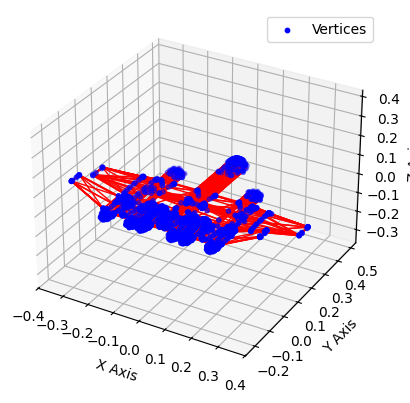

torch.Size([2249, 3])


In [33]:
vertices_np, edges_np= train_dataset[1].x.cpu().numpy(), train_dataset[1].edge_index.cpu().numpy()
visualize_3d(vertices_np, edges_np)
print(train_dataset[1].x.size())


In [34]:
from torch_geometric.data import DataLoader

def pad_graph(data, max_node_count, node_dim=3):
    num_nodes = data.x.size(0)
    mask = torch.zeros(max_node_count, dtype=torch.bool, device=data.x.device)
    mask[:num_nodes] = 1  # 1 for real nodes, 0 for padded nodes

    # Pad node features
    padded_x = pad_tensor(data.x, (max_node_count, node_dim), padding_value=0.0)

    # Pad adjacency matrix
    target_adj = to_dense_adj(data.edge_index).squeeze(0)
    padded_adj = pad_tensor(target_adj, (max_node_count, max_node_count), padding_value=0.0)

    data.x = padded_x
    data.adj = padded_adj
    data.mask = mask
    return data

# Apply padding in the data loader
train_loader = DataLoader([pad_graph(d, max_node_count) for d in train_dataset], batch_size=1, shuffle=True)
val_loader = DataLoader([pad_graph(d, max_node_count) for d in val_dataset], batch_size=1)

torch.Size([2500, 3])


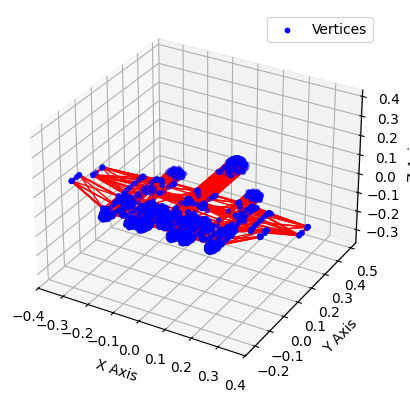

In [35]:
datapoint = pad_graph(train_dataset[1], max_node_count)
vertices_np, edges_np = datapoint.x.cpu().numpy(), datapoint.edge_index.cpu().numpy()
print(datapoint.x.size())
visualize_3d(vertices_np, edges_np)

# Train Step

In [ ]:
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj

def train_one_epoch(model, data_loader, optimizer, device, epoch, max_node_count=10000):
    set_mode(model, mode="train")
    total_loss = 0
    print("Training...",len(data_loader))
    
    for i, data in enumerate(data_loader):
        data = data.to(device)
        text_input_ids = data.text_label  
        
        graph_x = data.x
        edge_index = data.edge_index

        
        c_text = model['text_encoder'](text_input_ids)
        z_G = model['graph_encoder'](graph_x, edge_index)
        fused_features = model['feature_fusion'](c_text, z_G)
        z_qG, _, vq_loss = model['vector_quantizer'](fused_features)
        true_num_nodes = torch.tensor(graph_x.size(0), device=device, dtype=torch.long)
        reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG, true_num_nodes)
        
        target_adj = to_dense_adj(edge_index).squeeze(0)
        loss_nodes , loss_adj = compute_loss(reconstructed_nodes, graph_x, reconstructed_adj, target_adj)
        loss = 10 * loss_nodes + loss_adj + 10* vq_loss
        
        optimizer.zero_grad()
        loss.backward()
        
        
        for name, module in model.items():
            factor = 10.0 if name in ['text_encoder', 'graph_encoder', 'vector_quantizer'] else 5.0
            for param in module.parameters():
                if param.grad is not None:
                    param.grad *= factor
        
        # Optionally, clip gradients after scaling
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        print(i)
        if i == len(data_loader) - 1 or i == 1:
            print(reconstructed_adj)
            print(f"Epoch {epoch+1}, Batch 1:")
            print(f"  reconstructed_nodes shape: {reconstructed_nodes.shape}")
            print(f"  reconstructed_nodes min: {reconstructed_nodes.min().item():.4f}, max: {reconstructed_nodes.max().item():.4f}")
            print(f"  reconstructed_adj shape: {reconstructed_adj.shape}")
            print(f"  reconstructed_adj min: {reconstructed_adj.min().item():.4f}, max: {reconstructed_adj.max().item():.4f}")
            print(f"  Node Reconstruction Loss: {10*loss_nodes.item():.4f} adj Reconstruction Loss: {loss_adj.item():.4f}")
            print(f"  VQ Loss: {100*vq_loss.item():.4f}")
            print(f"  Total Loss: {loss.item():.4f}")

            print("Decoder")
            for name, param in model['graph_decoder'].named_parameters():
                if param.grad is not None:
                    print(f"  Grad {name}: {param.grad.abs().mean().item():.6f}")
                else:
                    print(f"  Grad {name}: None")

            print("vector_quantizer")
            for name, param in model['vector_quantizer'].named_parameters():
                if param.grad is not None:
                    print(f"  Grad {name}: {param.grad.abs().mean().item():.6f}")
                else:
                    print(f"  Grad {name}: None")
            print("FeatureFusion")
            for name, param in model['feature_fusion'].named_parameters():
                if param.grad is not None:
                    print(f"  Grad {name}: {param.grad.abs().mean().item():.6f}")
                else:
                    print(f"  Grad {name}: None")
            print("graph_encoder")
            for name, param in model['graph_encoder'].named_parameters():
                if param.grad is not None:
                    print(f"  Grad {name}: {param.grad.abs().mean().item():.6f}")
                else:
                    print(f"  Grad {name}: None")
            print("text_encoder")
            for name, param in model['text_encoder'].named_parameters():
                if param.grad is not None:
                    print(f"  Grad {name}: {param.grad.abs().mean().item():.6f}")
                else:
                    print(f"  Grad {name}: None")
                
            # Uncomment to visualize
            nodes = reconstructed_nodes.cpu().detach().numpy()
            adj = torch.sigmoid(reconstructed_adj).cpu().detach().numpy()
            visualize_graph(nodes, adj, epoch)

        optimizer.step()
        total_loss += loss.item()   
    
    return total_loss / len(data_loader)


# evaluation

In [37]:
def evaluate(model, data_loader, device):
    set_mode(model, mode="eval")
    total_loss = 0

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            text_input_ids = data.text_label  # shape: [batch_size, seq_len]
        # Optionally, if available:
           
            graph_x = data.x
            edge_index = data.edge_index

        # Pass tokenized text through the BertTextEncoder
            c_text = model['text_encoder'](text_input_ids)
            z_G = model['graph_encoder'](graph_x, edge_index)
            fused_features = model['feature_fusion'](c_text, z_G)
            z_qG, _, vq_loss = model['vector_quantizer'](fused_features)
            true_num_nodes = torch.tensor(graph_x.size(0), device=device, dtype=torch.long)  # Convert to tensor
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG,true_num_nodes)

            target_adj = to_dense_adj(edge_index).squeeze(0)

            loss_nodes , loss_adj = compute_loss(reconstructed_nodes, graph_x, reconstructed_adj, target_adj)
            vq_loss = F.mse_loss(fused_features, z_qG.detach())  # Vector quantization loss
            loss = 1 * loss_nodes + loss_adj + 0.25 * vq_loss

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [38]:
def infer_and_decode(model, data, device):
    set_mode(model, mode="eval")  # Set model to evaluation mode
    with torch.no_grad():
        data = data.to(device)
        text_input = data.text_label
        graph_x = data.x
        edge_index = data.edge_index

        # Encode
        c_text = model['text_encoder'](text_input)
        z_G = model['graph_encoder'](graph_x, edge_index)
        fused_features = model['feature_fusion'](c_text, z_G)
        z_qG, _, vq_loss = model['vector_quantizer'](fused_features)
        true_num_nodes = torch.tensor(graph_x.size(0), device=device, dtype=torch.long)  # Convert to tensor
        reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG,true_num_nodes)
        
        return reconstructed_nodes.cpu().numpy(), reconstructed_adj.cpu().numpy()

# Main

In [43]:
from torch.optim import Adam
from torch_geometric.data import DataLoader

def main_training(num_epochs=40, batch_size=1, learning_rate=1e-3, patience=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = Adam([
        {'params': model['text_encoder'].parameters(), 'lr': 2e-3},
        {'params': model['graph_encoder'].parameters(), 'lr': 2e-3},
        {'params': model['feature_fusion'].parameters(), 'lr': 1e-3},
        {'params': model['vector_quantizer'].parameters(), 'lr': 1e-2},
        {'params': model['graph_decoder'].parameters(), 'lr':2e-3}
    ])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
        val_loss = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({name: part.state_dict() for name, part in model.items()}, "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    with torch.no_grad():
        for data in val_loader:
            nodes, adj = infer_and_decode(model, data, device)
            visualize_graph(nodes, adj, epoch)
            break
    checkpoint = torch.load("best_model.pth")
    for name, part in model.items():
        part.load_state_dict(checkpoint[name])
    test_loss = evaluate(model, DataLoader(test_dataset, batch_size=batch_size), device)
    print(f"Test Loss: {test_loss:.4f}")

# Train

Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 1, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0899, max: 0.1264
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 1.0306
  Node Reconstruction Loss: 1.2486 adj Reconstruction Loss: 0.6957
  VQ Loss: 1.5601
  Total Loss: 2.1003
Decoder
  Grad node_decoder.0.weight: 0.000973
  Grad node_decoder.0.bias: 0.044325
  Grad node_decoder.3.weight: 0.381513
  Grad node_decoder.3.bias: 24.477278
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000006
  Grad edge_decoder.mlp.3.weight: 0.000111
  Grad edge_decoder.mlp.3.bias: 0.007101
vector_quantizer
  Grad codeb

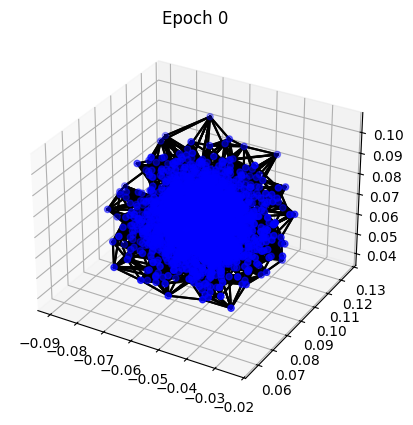

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

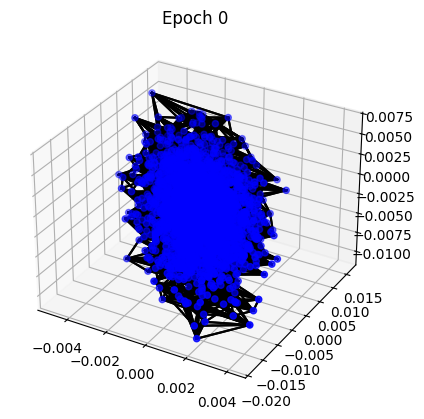

Epoch 1/40 - Train Loss: 1.6248, Val Loss: 0.7739
Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 2, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0167, max: 0.0171
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.2629
  Node Reconstruction Loss: 0.9938 adj Reconstruction Loss: 0.6935
  VQ Loss: 0.0008
  Total Loss: 1.6874
Decoder
  Grad node_decoder.0.weight: 0.000304
  Grad node_decoder.0.bias: 0.003111
  Grad node_decoder.3.weight: 0.047667
  Grad node_decoder.3.bias: 3.077545
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000007
  Grad edge_decoder.mlp.3.weight: 0.000029
  Grad edge_decoder.m

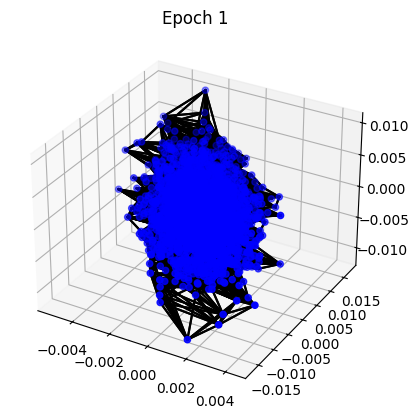

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

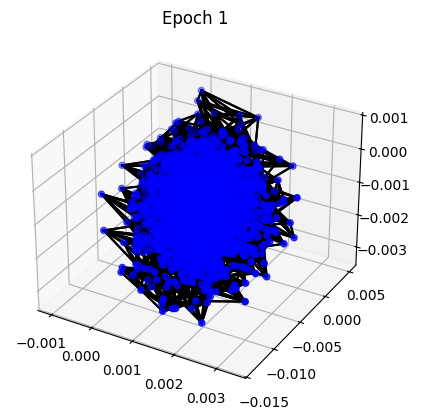

Epoch 2/40 - Train Loss: 1.5742, Val Loss: 0.7736
Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 3, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0177, max: 0.0043
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.1631
  Node Reconstruction Loss: 0.9141 adj Reconstruction Loss: 0.6933
  VQ Loss: 0.0002
  Total Loss: 1.6074
Decoder
  Grad node_decoder.0.weight: 0.000158
  Grad node_decoder.0.bias: 0.001403
  Grad node_decoder.3.weight: 0.049170
  Grad node_decoder.3.bias: 3.114278
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000002
  Grad edge_decoder.mlp.3.weight: 0.000009
  Grad edge_decoder.m

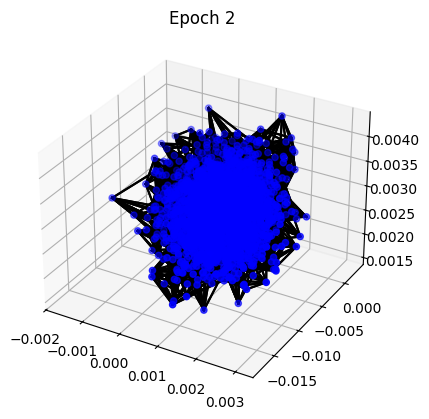

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

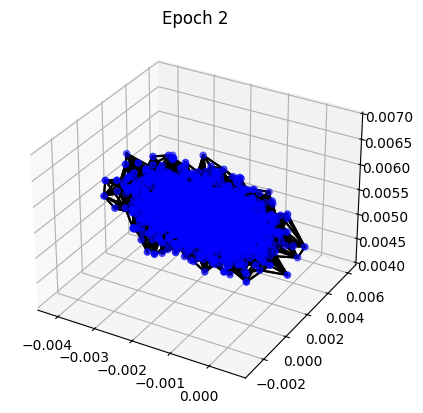

Epoch 3/40 - Train Loss: 1.5735, Val Loss: 0.7735
Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 4, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0044, max: 0.0051
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.1301
  Node Reconstruction Loss: 0.3844 adj Reconstruction Loss: 0.6932
  VQ Loss: 0.0001
  Total Loss: 1.0777
Decoder
  Grad node_decoder.0.weight: 0.000046
  Grad node_decoder.0.bias: 0.000102
  Grad node_decoder.3.weight: 0.012513
  Grad node_decoder.3.bias: 0.705638
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000001
  Grad edge_decoder.mlp.3.weight: 0.000004
  Grad edge_decoder.m

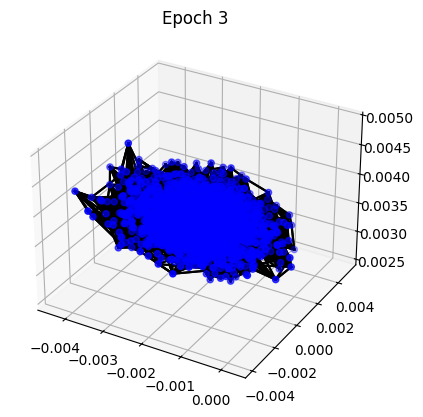

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

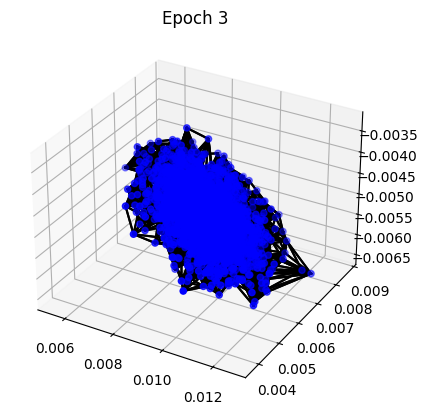

Epoch 4/40 - Train Loss: 1.5736, Val Loss: 0.7739
Training... 644
0
1
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0110],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0110, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<AddBackward0>)
Epoch 5, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0064, max: 0.0097
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.1064
  Node Reconstruction Loss: 0.7007 adj Reconstruction Loss: 0.6932
  VQ Loss: 0.0000
  Total Loss: 1.3939
Decoder
  Grad node_decoder.0.weight: 0.000047
  Grad node_decoder.0.bias: 0.000481
  Grad node_decoder.3.weight: 0.050402
  Grad node_decoder.3.bias: 3.153762
  Gr

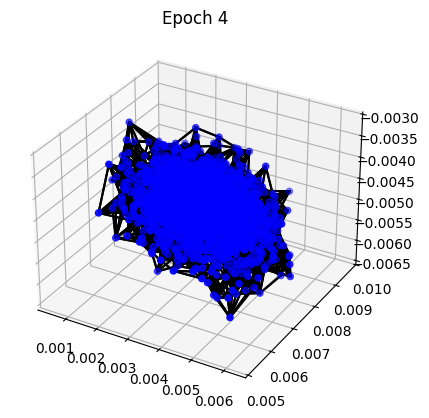

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

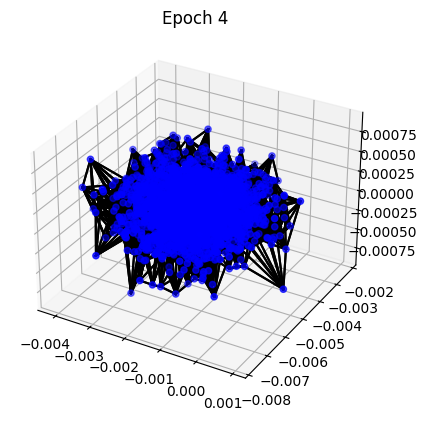

Epoch 5/40 - Train Loss: 1.5737, Val Loss: 0.7735
Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 6, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0079, max: 0.0001
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.0721
  Node Reconstruction Loss: 0.4028 adj Reconstruction Loss: 0.6932
  VQ Loss: 0.0001
  Total Loss: 1.0960
Decoder
  Grad node_decoder.0.weight: 0.000031
  Grad node_decoder.0.bias: 0.000200
  Grad node_decoder.3.weight: 0.027518
  Grad node_decoder.3.bias: 1.749045
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000000
  Grad edge_decoder.mlp.3.weight: 0.000002
  Grad edge_decoder.m

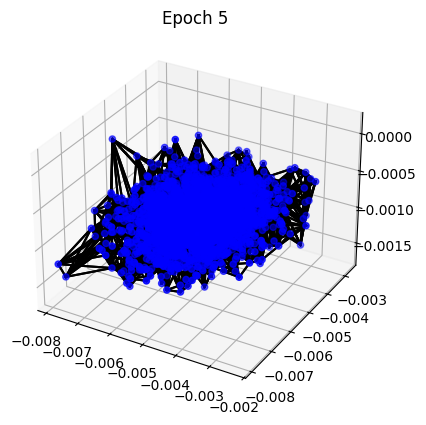

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

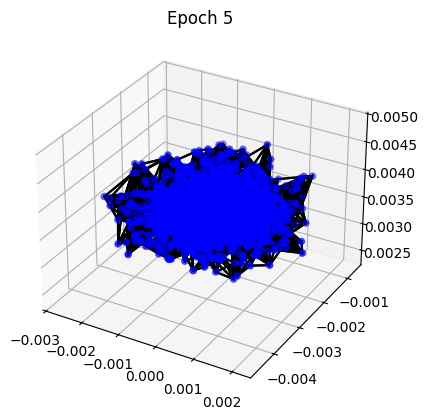

Epoch 6/40 - Train Loss: 1.5732, Val Loss: 0.7734
Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 7, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0047, max: 0.0027
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.0622
  Node Reconstruction Loss: 0.8617 adj Reconstruction Loss: 0.6932
  VQ Loss: 0.0000
  Total Loss: 1.5548
Decoder
  Grad node_decoder.0.weight: 0.000036
  Grad node_decoder.0.bias: 0.000069
  Grad node_decoder.3.weight: 0.008477
  Grad node_decoder.3.bias: 0.327451
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000000
  Grad edge_decoder.mlp.3.weight: 0.000001
  Grad edge_decoder.m

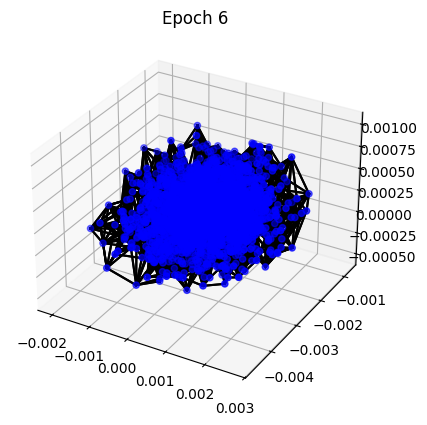

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

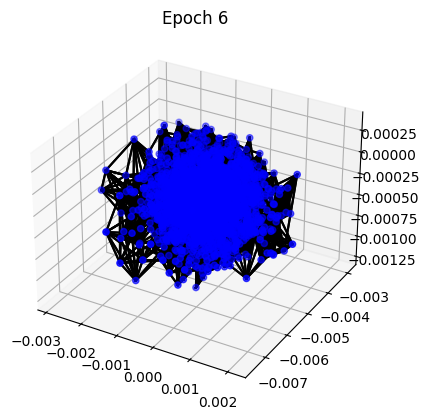

Epoch 7/40 - Train Loss: 1.5734, Val Loss: 0.7735
Training... 644
0
1
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddBackward0>)
Epoch 8, Batch 1:
  reconstructed_nodes shape: torch.Size([2500, 3])
  reconstructed_nodes min: -0.0072, max: 0.0021
  reconstructed_adj shape: torch.Size([2500, 2500])
  reconstructed_adj min: 0.0000, max: 0.0502
  Node Reconstruction Loss: 0.8587 adj Reconstruction Loss: 0.6932
  VQ Loss: 0.0000
  Total Loss: 1.5518
Decoder
  Grad node_decoder.0.weight: 0.000039
  Grad node_decoder.0.bias: 0.000065
  Grad node_decoder.3.weight: 0.010133
  Grad node_decoder.3.bias: 0.422091
  Grad edge_decoder.mlp.0.weight: 0.000000
  Grad edge_decoder.mlp.0.bias: 0.000000
  Grad edge_decoder.mlp.3.weight: 0.000001
  Grad edge_decoder.m

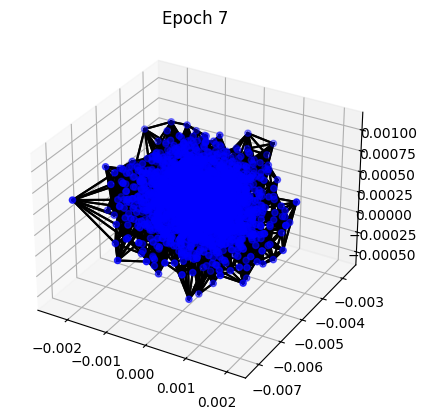

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

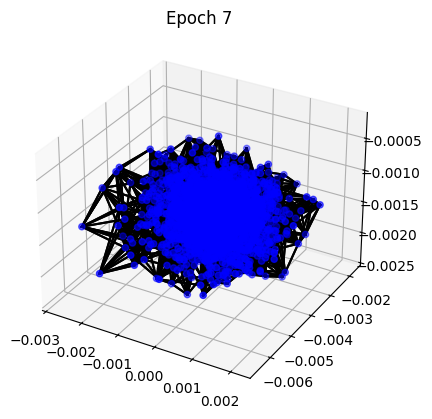

Epoch 8/40 - Train Loss: 1.5737, Val Loss: 0.7735
Early stopping triggered.


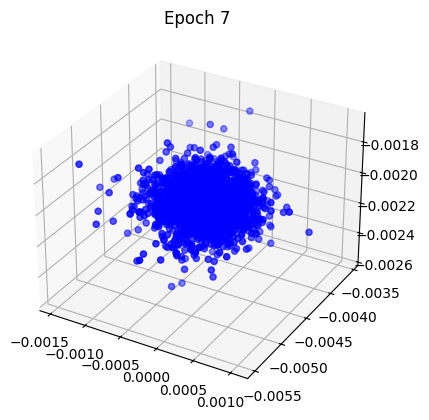

C:\Users\Danilka\AppData\Local\Temp\ipykernel_63304\592508183.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth")


Test Loss: 0.8343


In [40]:
main_training()


In [41]:
def train_lstm_feature_fusion(model, data_loader, optimizer, device, num_epochs=10):
    model['lstm_feature_fusion'].train()
    model['text_encoder'].eval()
    model['graph_encoder'].eval()
    model['feature_fusion'].eval()
    total_loss = 0
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        latent_features_accumulated = [] 
        for data in data_loader:
            data = data.to(device)

            # Generate Ground Truth from Pretrained Feature Fusion
            text_embeddings = model['text_encoder'](data.text_label.unsqueeze(1))  # [batch_size, seq_len, embed_dim]
            z_G = model['graph_encoder'](data.x, data.edge_index)  # Graph features

            # Ground Truth Feature Fusion Output
            fused_features = model['feature_fusion'](text_embeddings, z_G)  # [batch_size, fused_dim]
            latent_features_accumulated.append(fused_features)
            # LSTM Prediction
            lstm_pred = model['lstm_feature_fusion'](text_embeddings)  # [batch_size, fused_dim]
            # Compute Loss
            loss = loss_fn(lstm_pred, fused_features)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        total_loss = epoch_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - LSTM Loss: {total_loss:.4f}")

    print("LSTM Training Complete!")


In [42]:

# Main Training Loop
def main_training(num_epochs=40, batch_size=1, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Optimizer
    optimizer = Adam(
        [param for part in model.values() for param in part.parameters()],
        lr=learning_rate,
    )

    # Load Data

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    train_lstm_feature_fusion(model, train_loader, optimizer, device,num_epochs)
        
    # print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training Complete!")

    # Testing
    test_loss = evaluate(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    
# Run the training
main_training()

AttributeError: 'dict' object has no attribute 'unsqueeze'

In [ ]:
torch.save({name: part.state_dict() for name, part in model.items()}, "trained_model.pth")



In [ ]:
def generate_feature_fusion_from_text(model, text_input, device):
    """
    Generate feature fusion output using only text embeddings.

    Args:
        model (dict): Trained model.
        text_input (Tensor): Tokenized text input [batch_size, seq_len, embed_dim].
        device: Torch device (cuda/cpu).

    Returns:
        Predicted feature fusion output [batch_size, fused_dim].
    """
    model['lstm_feature_fusion'].eval()
    model['text_encoder'].eval()
    model['graph_encoder'].eval()
    model['feature_fusion'].eval()
    with torch.no_grad():
        text_embeddings = model['text_encoder'](text_input.unsqueeze(1))  # [batch_size, seq_len, embed_dim]
        predicted_fused_features = model['lstm_feature_fusion'](text_embeddings)  # [batch_size, fused_dim]
    
    return predicted_fused_features

inputs = tokenizer("The 3D model features a central fuselage with two horizontal wings mounted symmetrically above, and a single vertical stabilizer at the rear. It includes a circular propeller at the front and two elongated landing gear elements beneath, creating a compact aircraft shape.", return_tensors="pt", padding=True, truncation=True, max_length=32)
input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

with torch.no_grad():
    outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
text_label_embedding = outputs.last_hidden_state.to(device)  # Pool the embeddings and move to device
print(text_label_embedding.shape)
pooled_text_label = text_label_embedding.mean(dim=1)
ff=generate_feature_fusion_from_text(model,pooled_text_label,device)
print(ff.size())

torch.Size([1, 32, 768])
torch.Size([1, 128])


In [ ]:
# def generate_graph_from_bert(model, bert_embedding, device):
#     """
#     Generate a graph using BERT embeddings and the codebook.
    
#     Args:
#         model: Dictionary containing the model components.
#         bert_embedding: Tensor of shape [1, embedding_dim] from BERT.
#         device: Device to run the model on (CPU or GPU).
#     """
#     # Move BERT embedding to the correct device
#     bert_embedding = bert_embedding.to(device)  # Shape: [1, embedding_dim]

#     # Quantize the BERT embedding
#     with torch.no_grad():
#         z_q, _ = model['vector_quantizer'](bert_embedding)  # Quantized representation

#     # Decode the quantized embeddings to generate graph
#     reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_q)
#     print("Reconstructed Nodes:", reconstructed_nodes)
#     print("Reconstructed Adjacency Matrix:", reconstructed_adj)

#     # Visualize the generated graph
#     visualize_3d(reconstructed_nodes, reconstructed_adj)

# # Example Usage
# generate_graph_from_bert(model, text_label_embedding, device)


In [ ]:
with torch.no_grad():
    model['vector_quantizer'].eval()
    model['graph_decoder'].eval()
    z_latent,_ = model['vector_quantizer'](ff)
    print(z_latent.size)
    new_nodes, new_adj = model['graph_decoder'](z_latent,2479)    
    print("Generated Nodes:", new_nodes.shape)
    print("Generated Adjacency Matrix:", new_adj.shape)

<built-in method size of Tensor object at 0x000001EAF598B890>
Generated Nodes: torch.Size([2479, 3])
Generated Adjacency Matrix: torch.Size([2479, 2479])


In [ ]:
import torch
import numpy as np

def adjacency_matrix_to_edge_list(adj_matrix):
    """
    Convert an adjacency matrix to an edge list.

    Args:
        adj_matrix (torch.Tensor or np.ndarray): Adjacency matrix of shape [num_nodes, num_nodes].

    Returns:
        edge_list (np.ndarray): Edge list of shape [2, num_edges].
    """
    adj_matrix = adj_matrix.cpu().numpy() if isinstance(adj_matrix, torch.Tensor) else adj_matrix
    edge_list = np.array(np.nonzero(adj_matrix))  # Extract non-zero entries (edges)
    return edge_list  # Shape: [2, num_edges]

# Convert adjacency matrix to edge list
edge_list = adjacency_matrix_to_edge_list(new_adj)

# Visualize the graph
visualize_3d(new_nodes.cpu().numpy(), edge_list)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001EAF4CF7600> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001EAF4D268E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
visualize_3d(vertices_np, edges_np)